## Inspect Results 

In [8]:
import os
import json

def count_experiment_stats(users_dict_path, target_run_id=None):
    """
    Counts basic stats for a given run_id across all user files.
    
    :param users_dict_path: Path to directory containing user .jsonl files
    :param target_run_id: Optional run_id to analyze. If None, uses latest from first file
    :return: Dictionary with counts and statistics
    """
    
    # Find all jsonl files
    user_files = [f for f in os.listdir(users_dict_path) if f.endswith('.jsonl')]
    if not user_files:
        print(f"No .jsonl files found in {users_dict_path}")
        return None
    
    total_files = len(user_files)
    files_with_run_data = 0
    
    # Get run_id if not provided
    if target_run_id is None:
        for uf in user_files:
            try:
                with open(os.path.join(users_dict_path, uf), 'r', encoding='utf-8') as f:
                    lines = f.readlines()
                    if len(lines) > 2:
                        runs_data = json.loads(lines[2].strip())
                        if runs_data.get('runs'):
                            target_run_id = runs_data['runs'][-1]['run_id']
                            print(f"Using run_id from {uf}: {target_run_id}")
                            break
            except (json.JSONDecodeError, IndexError, FileNotFoundError):
                continue
    
    if not target_run_id:
        print("Could not determine run_id")
        return None
    
    # Count stats
    user_stats = {}
    
    for user_file in user_files:
        user_file_path = os.path.join(users_dict_path, user_file)
        user_id = os.path.splitext(user_file)[0]
        
        try:
            with open(user_file_path, 'r', encoding='utf-8') as f:
                lines = f.readlines()
            
            # Get actual user_id from file if available
            if len(lines) > 0:
                user_info = json.loads(lines[0].strip())
                if 'user_id' in user_info:
                    user_id = user_info['user_id']
            
            # Check if this file has run data for our target run
            has_run_data = False
            imitation_count = 0
            
            if len(lines) > 2:
                try:
                    runs_content = json.loads(lines[2].strip())
                    target_run = next((r for r in runs_content.get('runs', []) 
                                     if r.get('run_id') == target_run_id), None)
                    if target_run:
                        has_run_data = True
                        imitation_count = len(target_run.get('imitations', []))
                except json.JSONDecodeError:
                    pass
            
            if has_run_data:
                files_with_run_data += 1
                
                # Count rounds (evaluations)
                round_count = 0
                if len(lines) > 3:
                    try:
                        eval_content = json.loads(lines[3].strip())
                        round_count = len([e for e in eval_content.get('evaluations', []) 
                                         if e.get('run_id') == target_run_id])
                    except json.JSONDecodeError:
                        pass
                
                user_stats[user_id] = {
                    'rounds': round_count,
                    'imitations': imitation_count
                }
        
        except Exception as e:
            print(f"Error processing {user_file}: {e}")
            continue
    
    # Summary
    results = {
        'run_id': target_run_id,
        'total_files_checked': total_files,
        'files_with_run_data': files_with_run_data,
        'total_users_in_run': len(user_stats),
        'user_stats': user_stats
    }
    
    return results

def print_summary(results):
    """Print a nice summary of the results"""
    if not results:
        print("No results to display")
        return
    
    print(f"\n=== EXPERIMENT SUMMARY ===")
    print(f"Run ID: {results['run_id']}")
    print(f"Files checked: {results['total_files_checked']}")
    print(f"Files with run data: {results['files_with_run_data']}")
    print(f"Users in this run: {results['total_users_in_run']}")
    
    if results['user_stats']:
        print(f"\nPer-user breakdown:")
        for user_id, stats in results['user_stats'].items():
            print(f"  {user_id}: {stats['rounds']} rounds, {stats['imitations']} imitations")
        
        # Quick stats
        rounds_list = [stats['rounds'] for stats in results['user_stats'].values()]
        imitations_list = [stats['imitations'] for stats in results['user_stats'].values()]
        
        print(f"\nQuick stats:")
        print(f"  Total rounds across all users: {sum(rounds_list)}")
        print(f"  Total imitations across all users: {sum(imitations_list)}")
        if rounds_list:
            print(f"  Average rounds per user: {sum(rounds_list)/len(rounds_list):.1f}")
        if imitations_list:
            print(f"  Average imitations per user: {sum(imitations_list)/len(imitations_list):.1f}")

# Usage example:
if __name__ == "__main__":
    # Replace with your actual path
    path = r"data\filtered_users"
    
    # Count stats for latest run (or specify run_id)
    results = count_experiment_stats(path, '2025_07_09_1446')
    
    if results:
        print_summary(results)


=== EXPERIMENT SUMMARY ===
Run ID: 2025_07_09_1446
Files checked: 127
Files with run data: 0
Users in this run: 0


# Round Perfomance 


In [1]:
import pandas as pd
import json
from round_analysis import RoundAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns

# Create analyzer instance
analyzer = RoundAnalyzer(users_directory="data/filtered_users")

# Get the raw data
df = analyzer.analyze_all_users()

# Function to extract metrics from nested data
def extract_metrics(df):
    """Extract evaluation metrics from nested data structure"""
    extracted_rows = []
    
    for _, row in df.iterrows():
        base_row = {
            'user_id': row['user_id'],
            'round': row['round'],
            'run_id': row['run_id'],
            'timestamp': row['timestamp']
        }
        
        # Extract from statistics dictionary
        if isinstance(row['statistics'], dict):
            stats = row['statistics']
            base_row['mean_combined_score'] = stats.get('mean_combined_score', 0)
            base_row['std_combined_score'] = stats.get('std_combined_score', 0)
            base_row['best_score'] = stats.get('best_score', 0)
            base_row['worst_score'] = stats.get('worst_score', 0)
        
        # Extract from overall dictionary/value
        if isinstance(row['overall'], dict):
            overall = row['overall']
            base_row['overall_score'] = overall.get('score', 0)
        elif isinstance(row['overall'], (int, float)):
            base_row['overall_score'] = row['overall']
        
        # Extract individual scores statistics
        if isinstance(row['individual_scores'], list):
            scores = []
            rouge_scores = []
            bleu_scores = []
            combined_scores = []
            
            for item in row['individual_scores']:
                if isinstance(item, dict):
                    # Extract combined score
                    if 'combined_score' in item:
                        combined_scores.append(item['combined_score'])
                    
                    # Extract ROUGE scores
                    if 'rouge' in item and isinstance(item['rouge'], dict):
                        rouge_scores.append(item['rouge'].get('rouge1', 0))
                    
                    # Extract BLEU scores
                    if 'bleu' in item and isinstance(item['bleu'], dict):
                        bleu_scores.append(item['bleu'].get('bleu', 0))
            
            # Calculate aggregated metrics
            if combined_scores:
                base_row['individual_mean_combined'] = sum(combined_scores) / len(combined_scores)
                base_row['individual_max_combined'] = max(combined_scores)
                base_row['individual_min_combined'] = min(combined_scores)
            
            if rouge_scores:
                base_row['individual_mean_rouge1'] = sum(rouge_scores) / len(rouge_scores)
                base_row['individual_max_rouge1'] = max(rouge_scores)
            
            if bleu_scores:
                base_row['individual_mean_bleu'] = sum(bleu_scores) / len(bleu_scores)
                base_row['individual_max_bleu'] = max(bleu_scores)
        
        extracted_rows.append(base_row)
    
    return pd.DataFrame(extracted_rows)

# Extract metrics
df_metrics = extract_metrics(df)

print("Extracted metrics columns:")
print(df_metrics.columns.tolist())
print("\nFirst few rows:")
print(df_metrics.head())

# Get numeric columns for analysis
numeric_cols = df_metrics.select_dtypes(include=['number']).columns
metric_cols = [col for col in numeric_cols if col != 'round']
print(f"\nMetric columns: {metric_cols}")


Extracted metrics columns:
['user_id', 'round', 'run_id', 'timestamp', 'mean_combined_score', 'std_combined_score', 'best_score', 'worst_score', 'overall_score', 'individual_mean_combined', 'individual_max_combined', 'individual_min_combined', 'individual_mean_rouge1', 'individual_max_rouge1', 'individual_mean_bleu', 'individual_max_bleu']

First few rows:
                 user_id  round                   run_id  \
0  1.063839405977338e+18      1  2025_07_09_1446_round_1   
1  1.063839405977338e+18      2  2025_07_09_1446_round_2   
2  1.063839405977338e+18      3  2025_07_09_1446_round_3   
3  1.063839405977338e+18      4  2025_07_09_1446_round_4   
4  1.063839405977338e+18      5  2025_07_09_1446_round_5   

                    timestamp  mean_combined_score  std_combined_score  \
0  2025-07-15T11:22:54.216095             0.268816            0.280992   
1  2025-07-15T12:18:46.703645             0.236595            0.201542   
2  2025-07-15T13:11:41.165481             0.208120        

In [2]:
# Calculate aggregated statistics by round
def get_round_statistics(df_metrics):
    """Get aggregated statistics by round"""
    if df_metrics.empty:
        return pd.DataFrame()
    
    numeric_cols = df_metrics.select_dtypes(include=['number']).columns
    metric_cols = [col for col in numeric_cols if col != 'round']
    
    if not metric_cols:
        return pd.DataFrame()
    
    # Group by round and calculate statistics
    aggregated = df_metrics.groupby('round')[metric_cols].agg([
        'mean', 'std', 'min', 'max', 'count'
    ]).round(4)
    
    # Flatten column names
    aggregated.columns = [f"{metric}_{stat}" for metric, stat in aggregated.columns]
    
    return aggregated.reset_index()

# Get aggregated results
aggregated_results = get_round_statistics(df_metrics)
print("\nAggregated Results by Round:")
print(aggregated_results)



Aggregated Results by Round:
    round  mean_combined_score_mean  mean_combined_score_std  \
0       1                    0.2163                   0.0619   
1       2                    0.2163                   0.0761   
2       3                    0.2271                   0.1007   
3       4                    0.2431                   0.0701   
4       5                    0.2518                   0.0903   
5       6                    0.2719                   0.1076   
6       7                    0.2493                   0.0950   
7       8                    0.2694                   0.1240   
8       9                    0.2735                   0.1129   
9      10                    0.2887                   0.1138   
10     11                    0.2580                   0.0923   
11     12                    0.2599                   0.0670   
12     13                    0.3190                   0.0461   
13     14                    0.2832                   0.1029   
14     15 

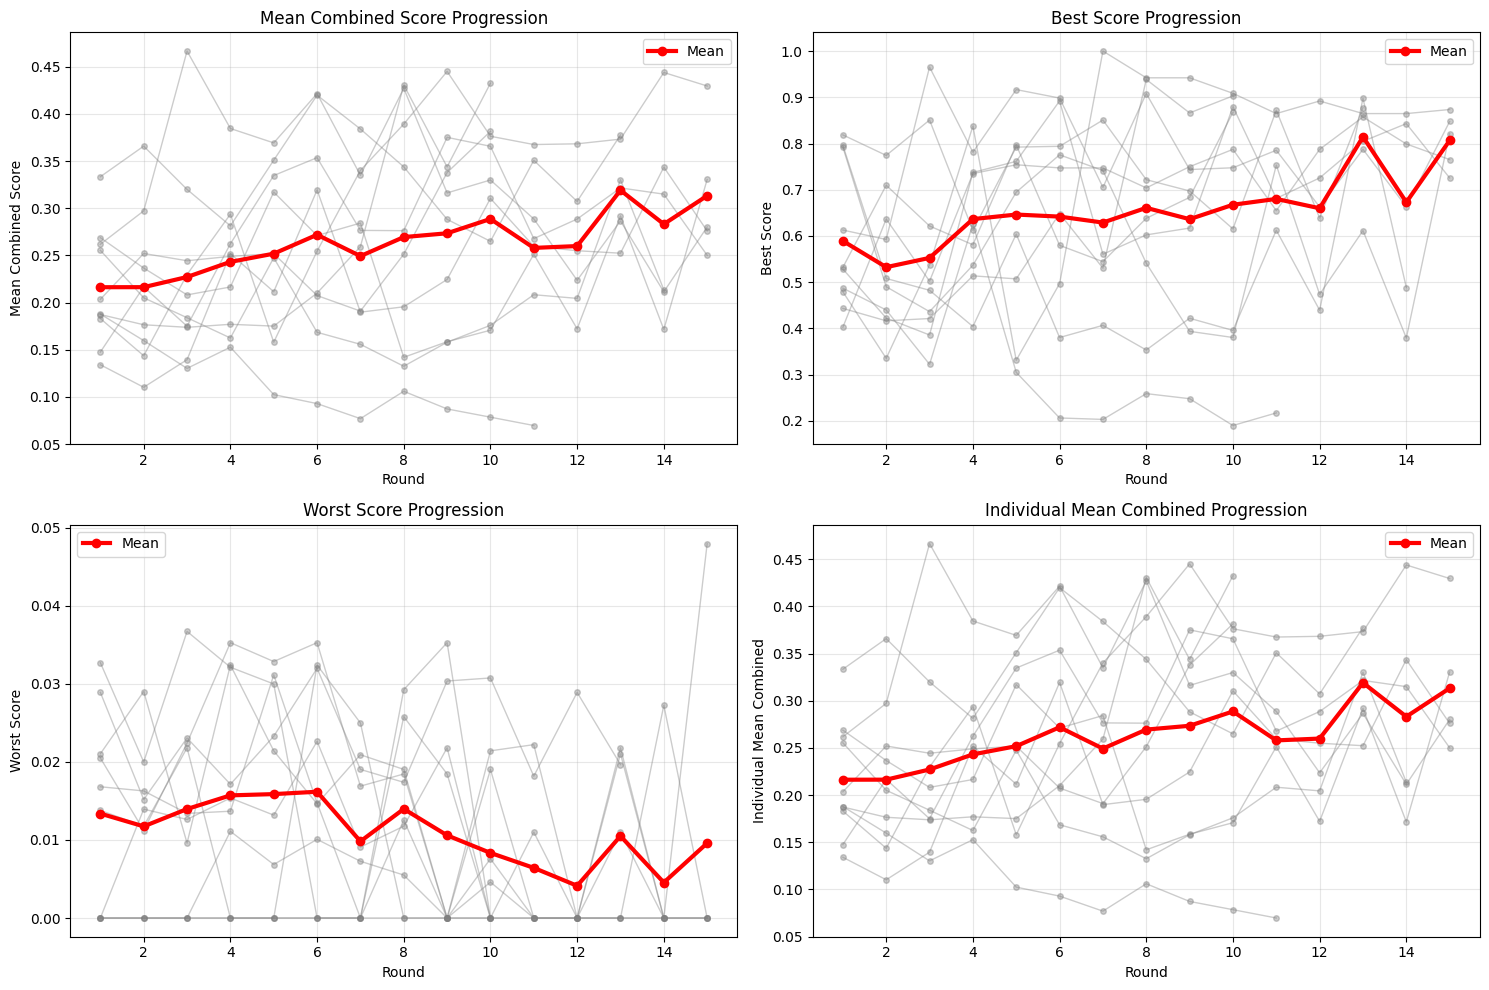

In [3]:
# Create progression plots
def plot_metric_progression(df_metrics, metrics=None):
    """Plot progression of metrics across rounds"""
    if df_metrics.empty:
        print("No data to plot")
        return
    
    # Default metrics to plot
    if metrics is None:
        metrics = ['mean_combined_score', 'best_score', 'worst_score', 'individual_mean_combined']
        # Filter to only existing columns
        metrics = [m for m in metrics if m in df_metrics.columns]
    
    if not metrics:
        print("No metrics available to plot")
        return
    
    # Create subplots
    n_metrics = len(metrics)
    n_cols = 2
    n_rows = (n_metrics + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    axes = axes.flatten()
    
    for i, metric in enumerate(metrics):
        ax = axes[i]
        
        # Individual user lines (light)
        for user_id in df_metrics['user_id'].unique():
            user_data = df_metrics[df_metrics['user_id'] == user_id].sort_values('round')
            if len(user_data) > 1:
                ax.plot(user_data['round'], user_data[metric], 
                       alpha=0.4, color='gray', linewidth=1, marker='o', markersize=4)
        
        # Aggregated mean line (bold)
        round_means = df_metrics.groupby('round')[metric].mean()
        ax.plot(round_means.index, round_means.values, 
               color='red', linewidth=3, marker='o', markersize=6, label='Mean')
        
        ax.set_title(f'{metric.replace("_", " ").title()} Progression')
        ax.set_xlabel('Round')
        ax.set_ylabel(metric.replace("_", " ").title())
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    # Remove empty subplots
    for i in range(len(metrics), len(axes)):
        fig.delaxes(axes[i])
    
    plt.tight_layout()
    plt.show()

# Plot progression
plot_metric_progression(df_metrics)
